In [270]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
top = mpl.colormaps['Reds_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
residual_cmp = ListedColormap(newcolors, name='RedsBlue')
from matplotlib.patches import Ellipse
import emcee
import corner
from radmc3dPy import image
import sys
sys.path.insert(0,'../../')
from X22_model.disk_model import *
from CB68.data_dict import data_dict
from radmc.setup import *
sys.path.insert(0,'../')
from fit_with_GIdisk.find_center import find_center
from astropy.coordinates import SkyCoord
import io
import contextlib

In [271]:
reader = emcee.backends.HDFBackend("progress.h5")

## Chain step 

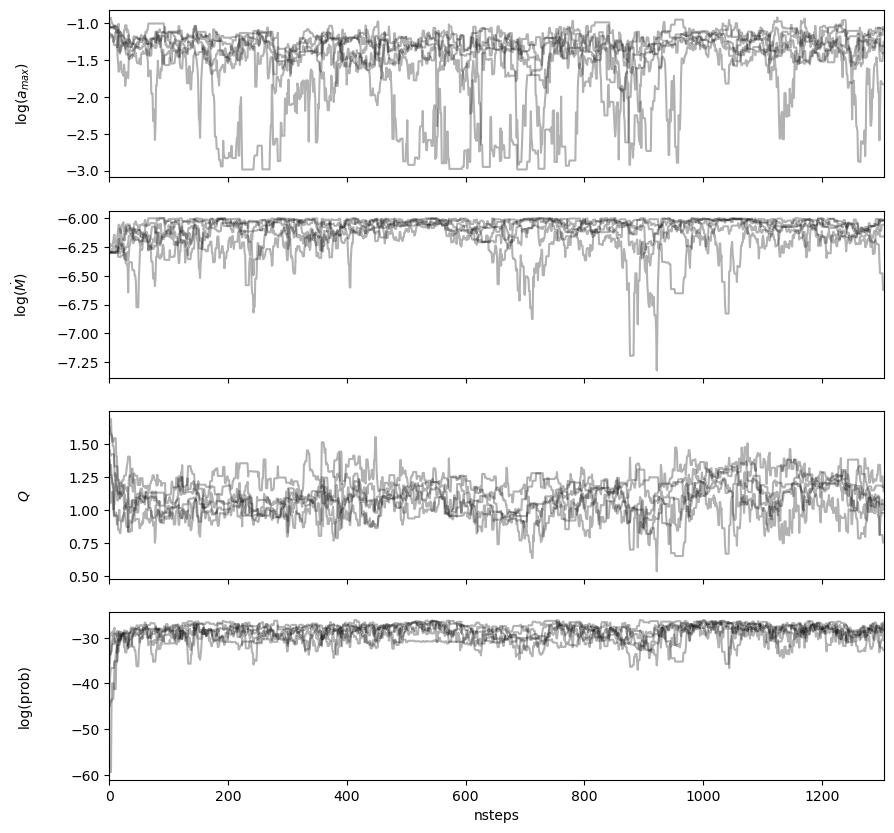

In [272]:
label = [r'log($a_{max}$)', r'log($\dot{M}$)', r"$Q$"]

fig, axes = plt.subplots(len(label)+1, figsize=(10, 10), sharex=True)
samples = reader.get_chain()
log_prob = reader.get_log_prob()

for i in range(len(label)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    # ax.set_xlim(0, len(samples))
    ax.set_ylabel(label[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].plot(log_prob, "k", alpha=0.3)
axes[-1].set_xlim(0, len(samples))
axes[-1].set_xlabel("nsteps")
axes[-1].set_ylabel("log(prob)")
axes[-1].yaxis.set_label_coords(-0.1, 0.5)

## Posterior

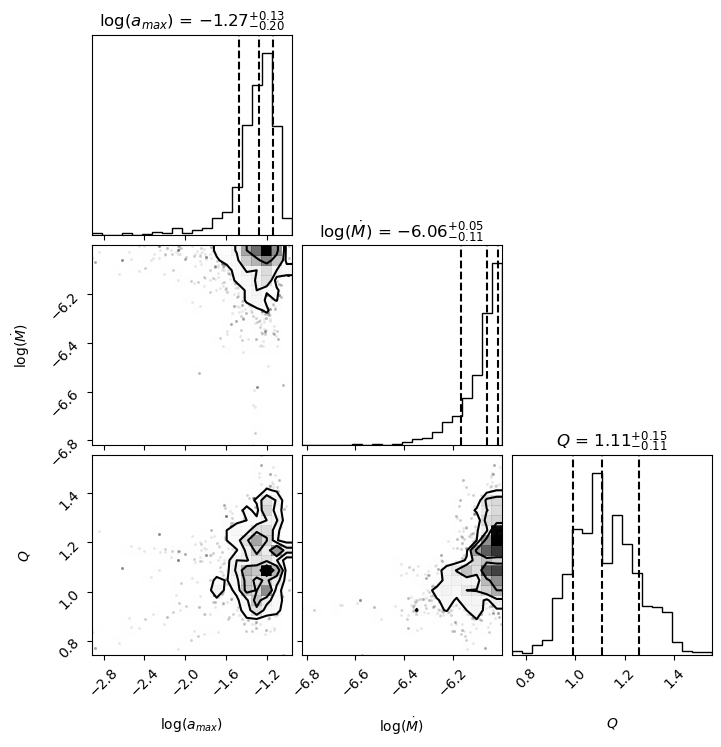

In [273]:
chains = reader.get_chain(discard=100, flat=False)
n_steps, n_walkers, n_params = chains.shape

acceptance_fractions = np.mean(
    np.diff(reader.get_log_prob(discard=100, flat=False), axis=0) != 0, axis=0
)

# Define a threshold for stuck walkers
threshold = 0.001
valid_walkers = np.where(acceptance_fractions > threshold)[0]

# Filter the chains to exclude stuck walkers
filtered_chains = chains[:, valid_walkers, :]

# Flatten the filtered chains
flat_samples = filtered_chains.reshape(-1, n_params)[::3]
fig = corner.corner(
    flat_samples[::], labels=label,
    show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])

## Best-fit parameters

In [274]:
samples = reader.get_chain(discard=100, flat=True)
theta_max = samples[np.argmax(reader.get_log_prob(flat=True, discard=100))]

print(f"Maximum grain size: {10**theta_max[0]:.2e} mm")
print(f"Accretion rate: {10**theta_max[1]:.2e} Msun/yr")
print(f"Toomre Q: {theta_max[2]:.2f}")

Maximum grain size: 6.39e-02 mm
Accretion rate: 9.95e-07 Msun/yr
Toomre Q: 1.22
